In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import irfft, rfft, rfftfreq
from scipy.signal import find_peaks

In [2]:
data = pd.read_csv('original_bioradio_1.csv',sep=',') #импорт данных, полученных с BioCapture

In [3]:
data

,,Elapsed Time,FP1,Fp2,BioRadio Event,Unnamed: 4
00:00:00,0,3.583305e+14,0,620372295379639,0.0,NaN
00:00:00.001,3,1.074030e+13,5,38007926940918,0.0,NaN
00:00:00.002,13,5.357037e+12,23,436393737793,0.0,NaN
00:00:00.003,40,4.446449e+12,70,301361083984,0.0,NaN
00:00:00.004,95,6.516266e+11,164,609161376953,0.0,NaN
...,...,...,...,...,...,...
00:18:39.835,27,5.903664e+12,21,4300727844238,0.0,NaN
00:18:39.836,25,8.963203e+11,19,3467655181885,0.0,NaN
00:18:39.837,22,6.196136e+12,17,3437519073486,0.0,NaN
00:18:39.838,20,1.966705e+12,15,4193296432495,0.0,NaN


In [4]:
data = data.reset_index()
#удаление ненужных столбцов, переименнование столбцов
data = data.drop(columns=['Elapsed Time','Fp2','BioRadio Event','Unnamed: 4']) \
            .rename(columns={'level_0':'Time','level_1':'Fp1','FP1':'Fp2'})
data

,Time,Fp1,Fp2
0,00:00:00,0,0
1,00:00:00.001,3,5
2,00:00:00.002,13,23
3,00:00:00.003,40,70
4,00:00:00.004,95,164
...,...,...,...
1119835,00:18:39.835,27,21
1119836,00:18:39.836,25,19
1119837,00:18:39.837,22,17
1119838,00:18:39.838,20,15


In [5]:
data = data.set_index('Time')

<AxesSubplot:xlabel='Time'>

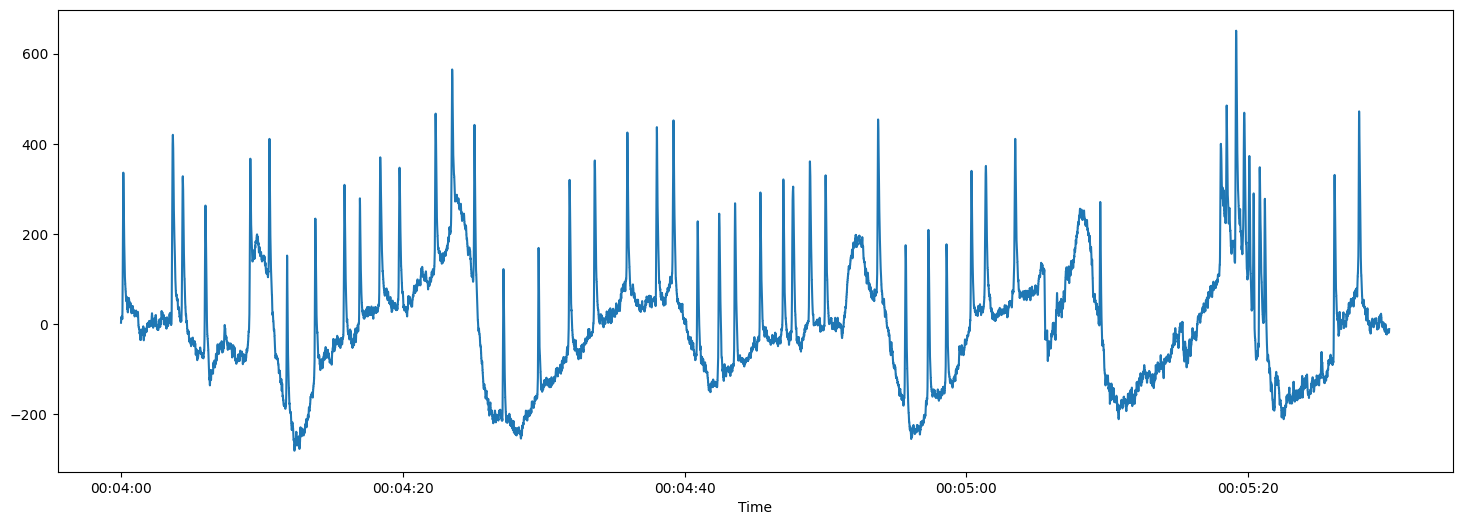

In [6]:
data['Fp1'][240000:330000].plot(figsize=(18,6)) #просмотр данных, видны сигналы ЭОГ

In [7]:
data

,Fp1,Fp2
Time,,
00:00:00,0,0
00:00:00.001,3,5
00:00:00.002,13,23
00:00:00.003,40,70
00:00:00.004,95,164
...,...,...
00:18:39.835,27,21
00:18:39.836,25,19
00:18:39.837,22,17


Сегментация на эксперименты

In [8]:
data_segment_fp1 = []
data_segment_fp2 = []

In [9]:
count = 11 #количество экспериментов
start_ind = 1000*60*4 #время начало эксперимента
for i in range(count):
    start_ind += 1000*5
    data_segment_fp1.append(data['Fp1'][start_ind:start_ind+1000*60].to_numpy())
    data_segment_fp2.append(data['Fp2'][start_ind:start_ind+1000*60].to_numpy())
    start_ind += 1000*75

In [10]:
data_segment_fp2

[array([-46, -46, -46, ...,  20,  20,  19], dtype=int64),
 array([93, 93, 92, ..., -2, -2, -2], dtype=int64),
 array([-145, -146, -148, ...,   63,   63,   63], dtype=int64),
 array([-5, -6, -6, ..., -8, -8, -7], dtype=int64),
 array([-45, -44, -43, ...,  -6,  -6,  -6], dtype=int64),
 array([-43, -42, -40, ..., -67, -66, -66], dtype=int64),
 array([ -40,  -39,  -38, ..., -207, -207, -207], dtype=int64),
 array([ -67,  -67,  -66, ..., -313, -312, -311], dtype=int64),
 array([ 113,  113,  113, ..., -163, -162, -161], dtype=int64),
 array([ 285,  286,  286, ..., -216, -217, -218], dtype=int64),
 array([  21,   20,   19, ..., -120, -124, -129], dtype=int64)]

In [11]:
len(data_segment_fp1[1])

60000

Удаление аномальных значений

In [12]:
def check_anomaly(arr):
    mean = arr.mean()
    std = arr.std()
    
    low_value = mean - std * 3
    high_value = mean + std * 3
    
    return [elem if elem < high_value and elem > low_value else mean for elem in arr]

In [13]:
data_segment_fp1[1].std()

80.65493250133903

In [14]:
for i in range(len(data_segment_fp1)):
    data_segment_fp1[i] = check_anomaly(data_segment_fp1[i])

for i in range(len(data_segment_fp2)):
    data_segment_fp2[i] = check_anomaly(data_segment_fp2[i])

Удаление EOG

In [15]:
begin_eog = 75
ending_eog = 175

def delete_eog(data,height):    
    for i in range(len(data)):
        peaks, _ = find_peaks(data[i], height=height)
        for elem in peaks:
            start = elem - begin_eog if elem - begin_eog > 0 else 0
            end = elem + ending_eog if elem + ending_eog < len(data[i]) else len(data[i]) -1    
            mean = (data[i][start] + data[i][end])/2
            data[i][start:end] = [mean] * (end-start)
    return data

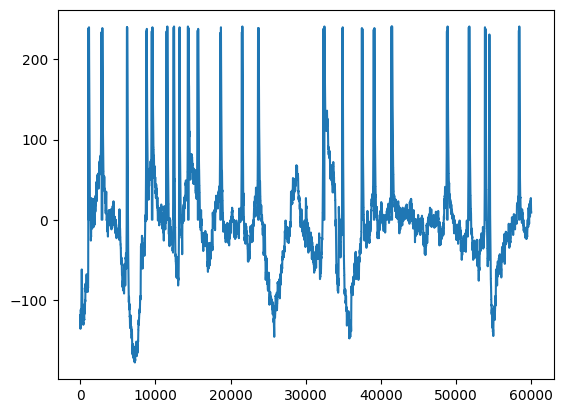

In [16]:
plt.plot(data_segment_fp1[1])
plt.show()

In [17]:
data_segment_fp1 = delete_eog(data_segment_fp1,150)
data_segment_fp2 = delete_eog(data_segment_fp2,150)

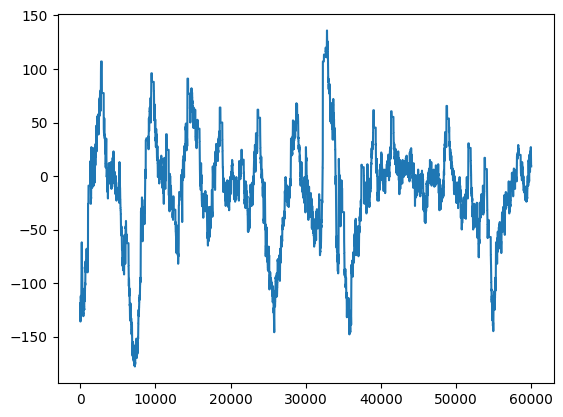

In [18]:
plt.plot(data_segment_fp1[1])
plt.show()

Понижение частоты до 128 HZ

In [19]:
def filt_freq(data):
    ans = []
    for elem in data:
        new_elem = []
        for i in range(0,len(elem),128):
            new_elem.append(np.mean(elem[i:i+128]))
        ans.append(new_elem)
    return ans

In [20]:
data_segment_fp1_128 = filt_freq(data_segment_fp1)    
data_segment_fp2_128 = filt_freq(data_segment_fp2)

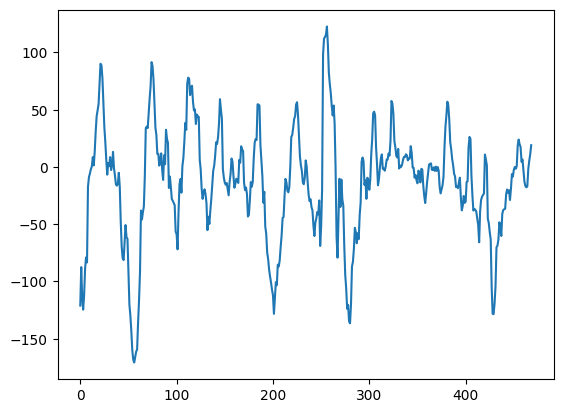

In [21]:
plt.plot(data_segment_fp1_128[1])
plt.show()

Применение полосового фильтра от 4 до 45 HZ

In [22]:
for i in range(len(data_segment_fp1_128)):
    y = rfft(data_segment_fp1_128[i]) # мощность волн определённой частоты на графике
    x = rfftfreq(len(data_segment_fp1_128[i]), 1 / 128)
    
    for ind in range(len(x)):
        if (x[ind] < 4) or (x[ind] > 45):
            y[ind] = 0
    
    data_segment_fp1_128[i] = irfft(y)

for i in range(len(data_segment_fp2_128)):
    y = rfft(data_segment_fp2_128[i]) # мощность волн определённой частоты на графике
    x = rfftfreq(len(data_segment_fp2_128[i]), 1 / 128)
    
    for ind in range(len(x)):
        if (x[ind] < 4) or (x[ind] > 45):
            y[ind] = 0
    
    data_segment_fp2_128[i] = irfft(y)

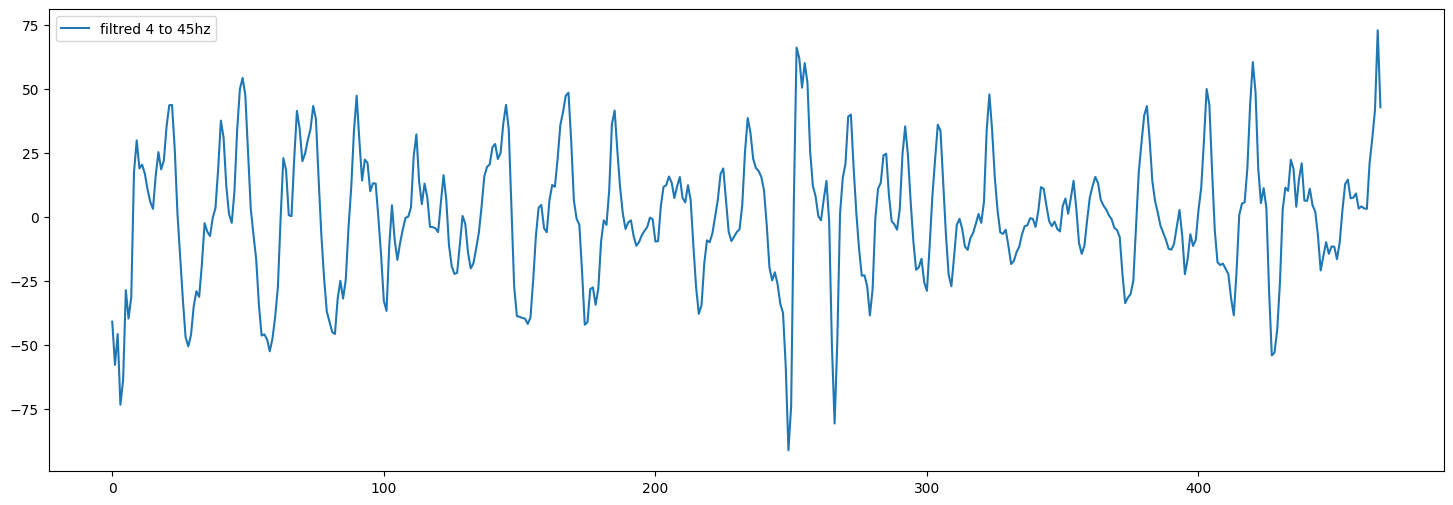

In [23]:
plt.figure(figsize=(18, 6)) 
plt.plot(data_segment_fp1_128[1],label='filtred 4 to 45hz')
plt.legend(loc='best')
plt.show()

In [24]:
len(data_segment_fp1_128[0])

468

Сохранение предобработки данных

In [25]:
pd.DataFrame(data_segment_fp1_128).to_csv('bioradio_1_fp1.csv')

In [26]:
pd.DataFrame(data_segment_fp2_128).to_csv('bioradio_1_fp2.csv')

Оценки

In [27]:
raitings = pd.DataFrame(columns=['valence','arousal','dominance','liking'])

In [28]:
raitings['valence'] = [7,5,7,2,5,7,8,7,8,5,7]

In [29]:
raitings['arousal'] = [7,7,3,2,7,3,3,2,7,1,5]

In [30]:
raitings['dominance'] = [6,3,6,2,8,3,5,3,5,4,5]

In [31]:
raitings['liking'] = [4,2,3,1,2,1,3,4,4,1,3]

In [32]:
raitings

,valence,arousal,dominance,liking
0,7,7,6,4
1,5,7,3,2
2,7,3,6,3
3,2,2,2,1
4,5,7,8,2
5,7,3,3,1
6,8,3,5,3
7,7,2,3,4
8,8,7,5,4
9,5,1,4,1


In [33]:
valence = []
for elem in raitings['valence']:
    if elem >= 5:
           valence.append(1)
    else:
           valence.append(0)
raitings['valence_model'] = valence

arousal = []
for elem in raitings['arousal']:
    if elem >= 5:
           arousal.append(1)
    else:
           arousal.append(0)
raitings['arousal_model'] = arousal

In [34]:
raitings

,valence,arousal,dominance,liking,valence_model,arousal_model
0,7,7,6,4,1,1
1,5,7,3,2,1,1
2,7,3,6,3,1,0
3,2,2,2,1,0,0
4,5,7,8,2,1,1
5,7,3,3,1,1,0
6,8,3,5,3,1,0
7,7,2,3,4,1,0
8,8,7,5,4,1,1
9,5,1,4,1,1,0


In [35]:
raitings.to_csv('bioradio_raiting_1.csv')

Обработка 2 участника

In [36]:
data = pd.read_csv('original_bioradio_2.csv',sep=',') #импорт данных, полученных с BioCapture

In [37]:
data

,,Elapsed Time,FP1,Fp2,BioRadio Event,Unnamed: 4
00:00:00,0,603495299816132,0,9.218061e+13,0.0,NaN
00:00:00.001,5,23411464691162,7,9.948912e+13,0.0,NaN
00:00:00.002,22,8027763366699,34,8.304138e+12,0.0,NaN
00:00:00.003,68,1448516845703,104,8.853149e+10,0.0,NaN
00:00:00.004,160,199127197266,244,6.955109e+11,0.0,NaN
...,...,...,...,...,...,...
00:21:07.064,-41,2142181396484,-52,6.840210e+12,0.0,NaN
00:21:07.065,-42,9602966308594,-65,3.824310e+12,0.0,NaN
00:21:07.066,-48,166618347168,-82,2.288971e+12,0.0,NaN
00:21:07.067,-56,4670562744141,-101,5.953445e+11,0.0,NaN


In [38]:
data = data.reset_index()
#удаление ненужных столбцов, переименнование столбцов
data = data.drop(columns=['Elapsed Time','Fp2','BioRadio Event','Unnamed: 4']) \
            .rename(columns={'level_0':'Time','level_1':'Fp1','FP1':'Fp2'})
data

,Time,Fp1,Fp2
0,00:00:00,0,0
1,00:00:00.001,5,7
2,00:00:00.002,22,34
3,00:00:00.003,68,104
4,00:00:00.004,160,244
...,...,...,...
1267064,00:21:07.064,-41,-52
1267065,00:21:07.065,-42,-65
1267066,00:21:07.066,-48,-82
1267067,00:21:07.067,-56,-101


In [39]:
data = data.set_index('Time')

<AxesSubplot:xlabel='Time'>

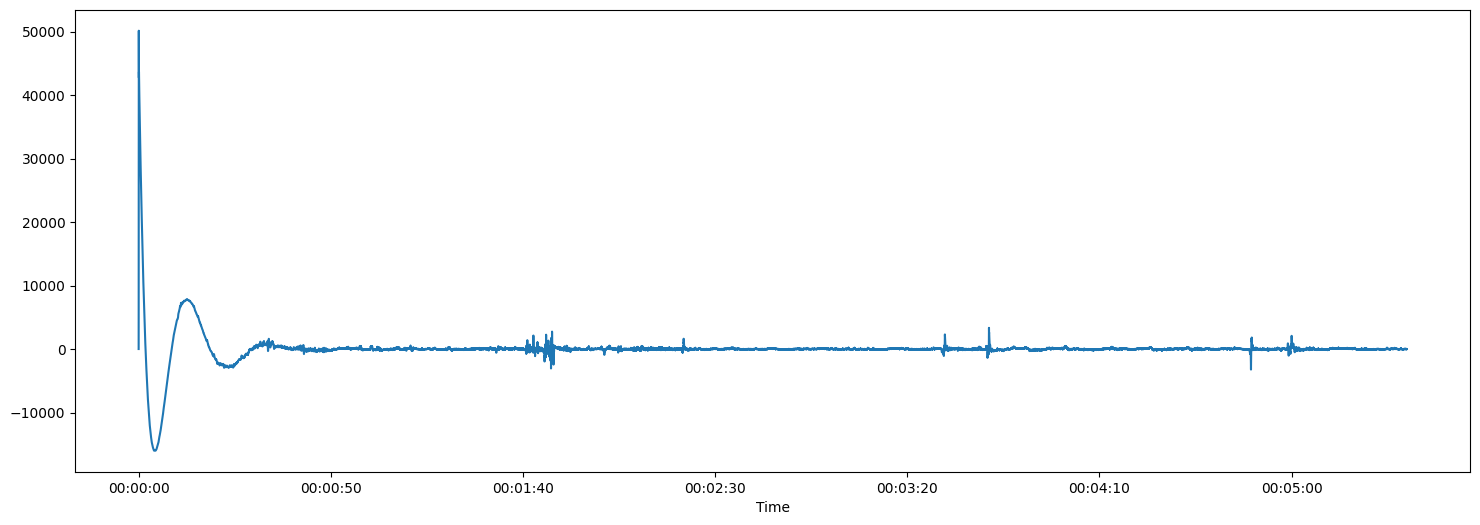

In [40]:
data['Fp1'][0:330000].plot(figsize=(18,6)) #просмотр данных, видны сигналы ЭОГ и много шумов

In [41]:
data

,Fp1,Fp2
Time,,
00:00:00,0,0
00:00:00.001,5,7
00:00:00.002,22,34
00:00:00.003,68,104
00:00:00.004,160,244
...,...,...
00:21:07.064,-41,-52
00:21:07.065,-42,-65
00:21:07.066,-48,-82


Сегментация данных

In [42]:
data_segment_fp1 = []
data_segment_fp2 = []

In [43]:
count = 14 #количество экспериментов
start_ind = int(1000*60*2.45) #время начало эксперимента
for i in range(count):
    start_ind += 1000*5
    data_segment_fp1.append(data['Fp1'][start_ind:start_ind+1000*60].to_numpy())
    data_segment_fp2.append(data['Fp2'][start_ind:start_ind+1000*60].to_numpy())
    start_ind += 1000*75

In [44]:
len(data_segment_fp2[0])

60000

Удаление аномалий

In [45]:
for i in range(len(data_segment_fp1)):
    data_segment_fp1[i] = check_anomaly(data_segment_fp1[i])

for i in range(len(data_segment_fp2)):
    data_segment_fp2[i] = check_anomaly(data_segment_fp2[i])

Удаление ЭОГ

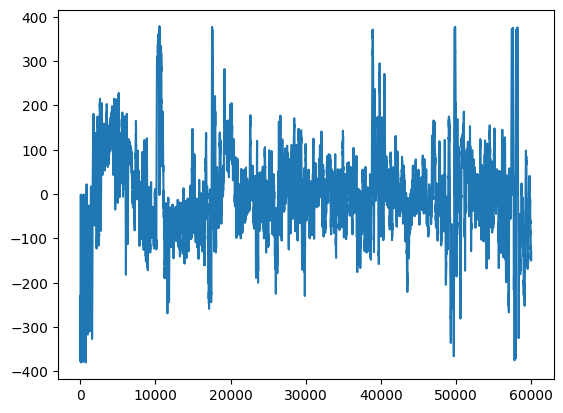

In [46]:
plt.plot(data_segment_fp1[4])
plt.show()

In [47]:
data_segment_fp1 = delete_eog(data_segment_fp1,100)
data_segment_fp2 = delete_eog(data_segment_fp2,100)

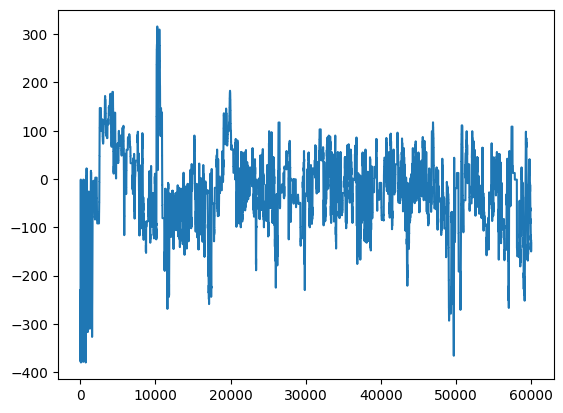

In [48]:
plt.plot(data_segment_fp1[4])
plt.show()

Понижение частоты 

In [49]:
data_segment_fp1_128 = filt_freq(data_segment_fp1)    
data_segment_fp2_128 = filt_freq(data_segment_fp2)

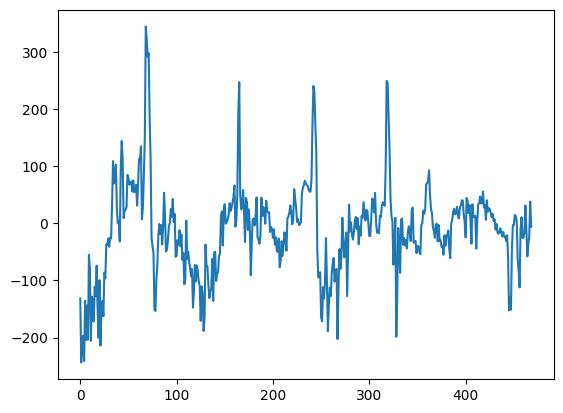

In [50]:
plt.plot(data_segment_fp1_128[1])
plt.show()

Применение полосового фильтра

In [51]:
for i in range(len(data_segment_fp1_128)):
    y = rfft(data_segment_fp1_128[i]) # мощность волн определённой частоты на графике
    x = rfftfreq(len(data_segment_fp1_128[i]), 1 / 128)
    
    for ind in range(len(x)):
        if (x[ind] < 4) or (x[ind] > 45):
            y[ind] = 0
    
    data_segment_fp1_128[i] = irfft(y)

for i in range(len(data_segment_fp2_128)):
    y = rfft(data_segment_fp2_128[i]) # мощность волн определённой частоты на графике
    x = rfftfreq(len(data_segment_fp2_128[i]), 1 / 128)
    
    for ind in range(len(x)):
        if (x[ind] < 4) or (x[ind] > 45):
            y[ind] = 0
    
    data_segment_fp2_128[i] = irfft(y)

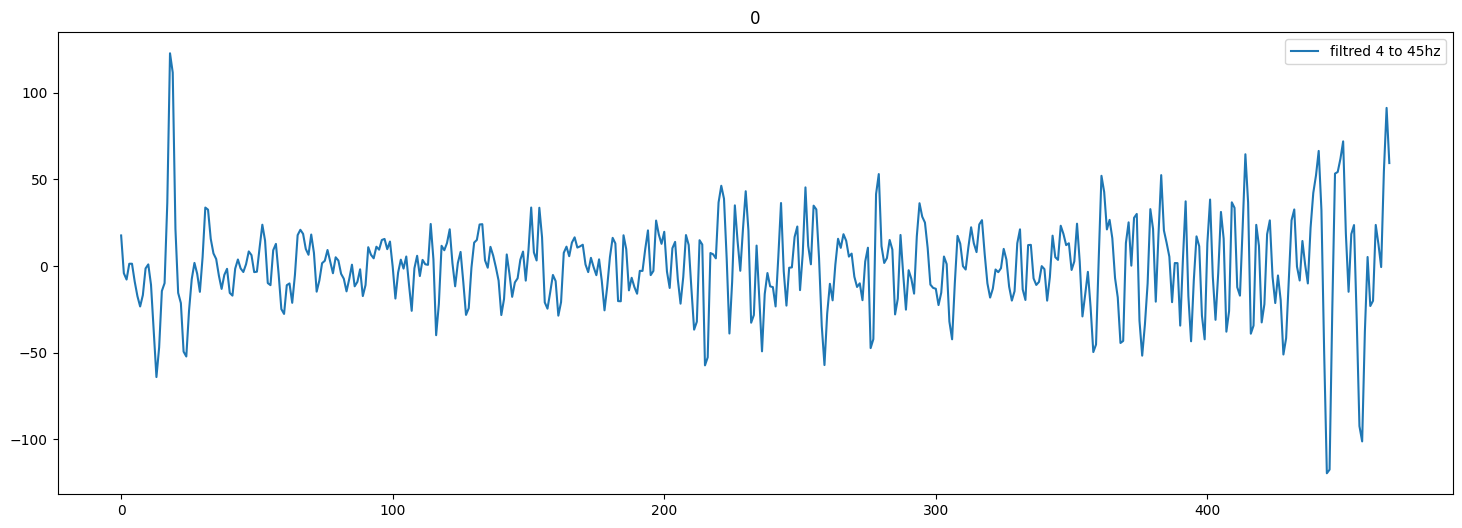

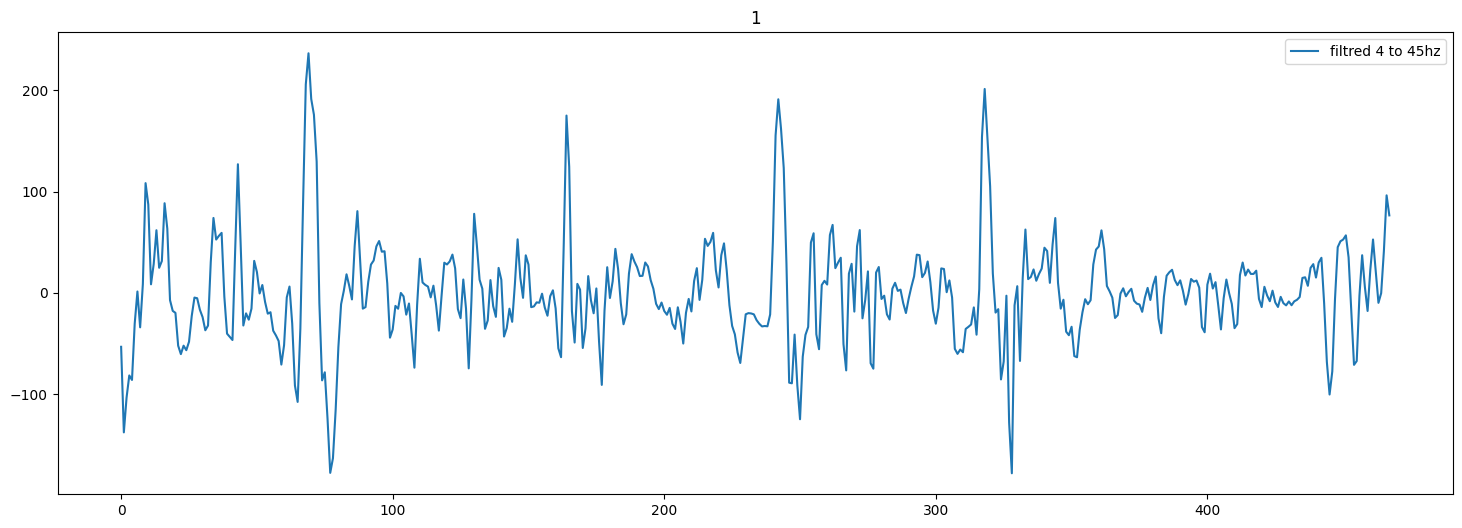

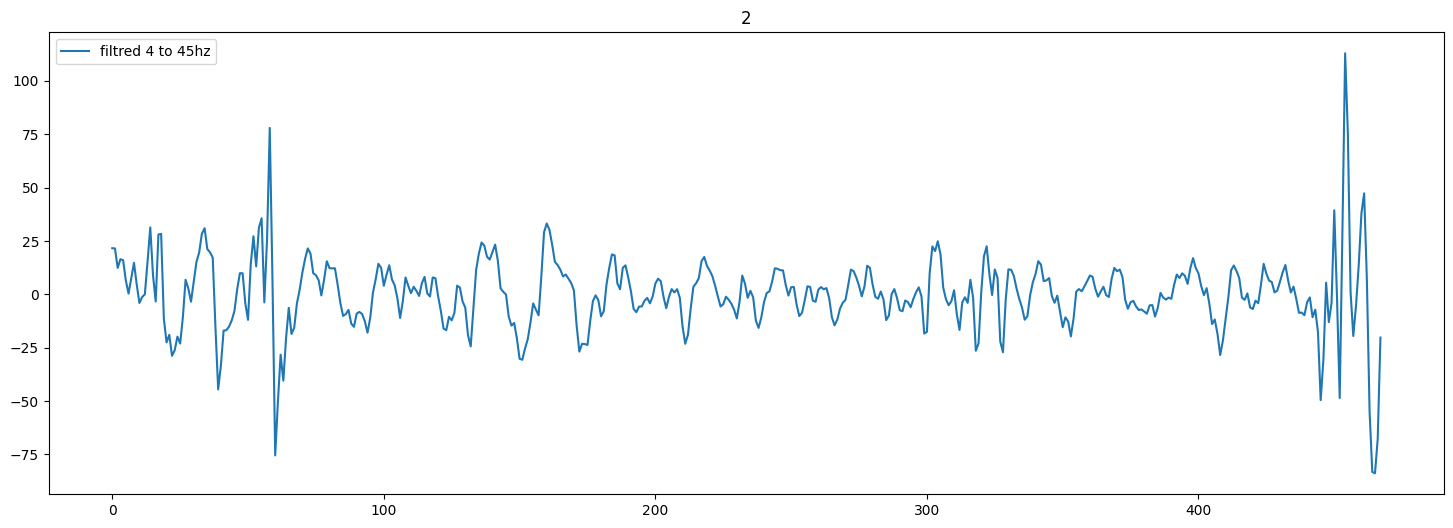

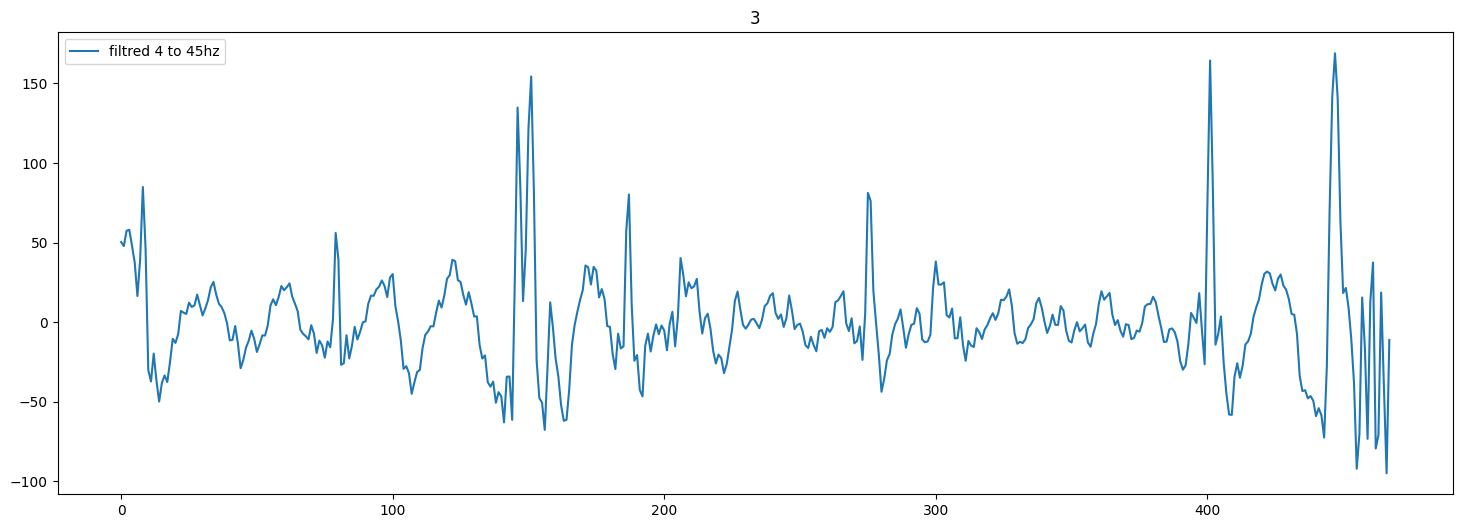

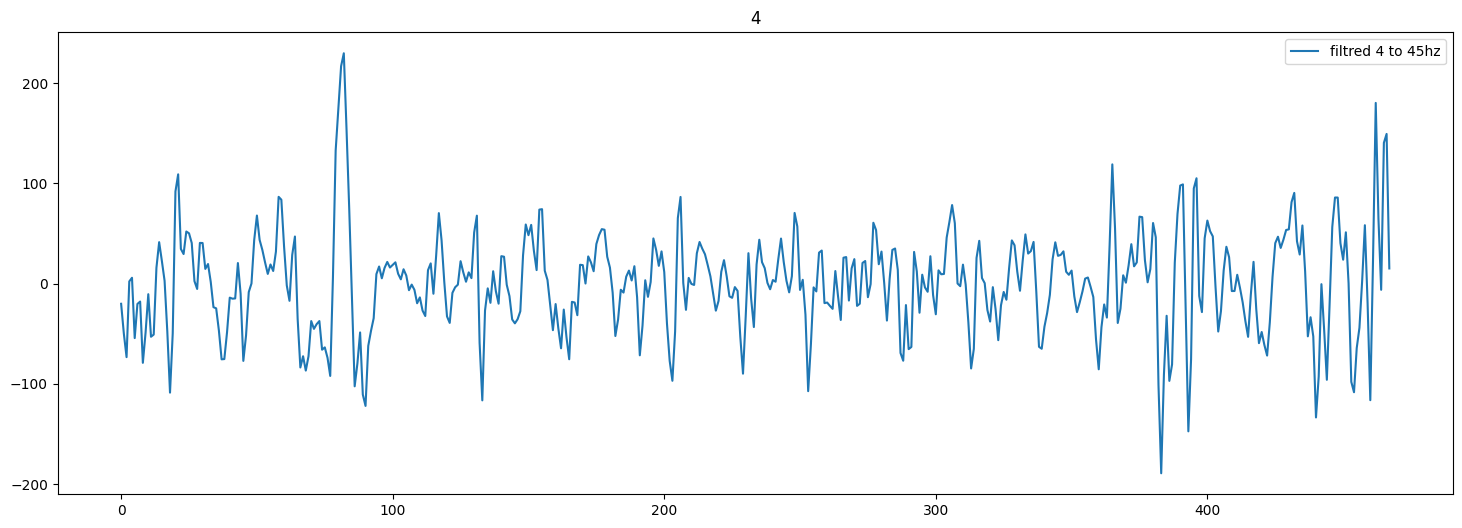

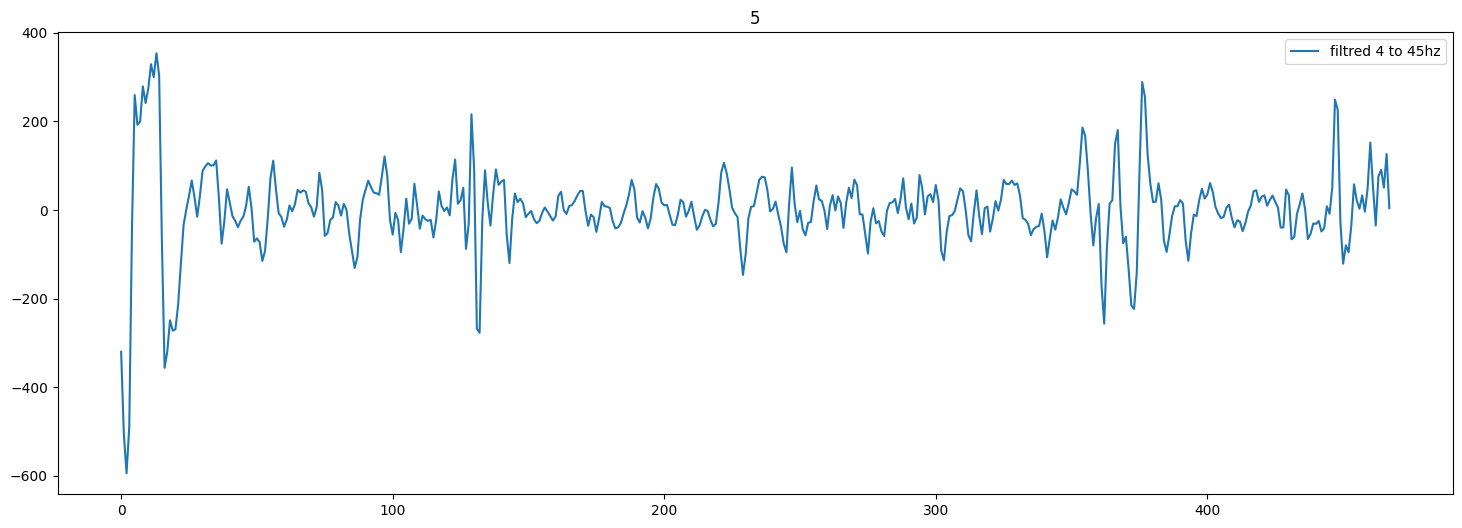

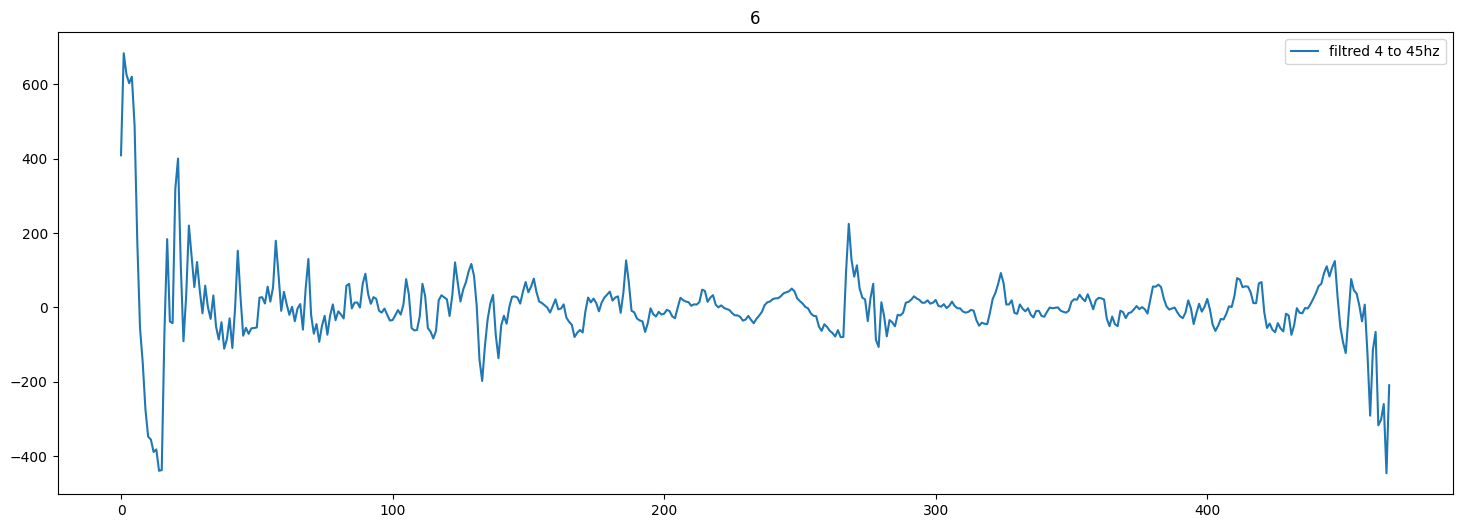

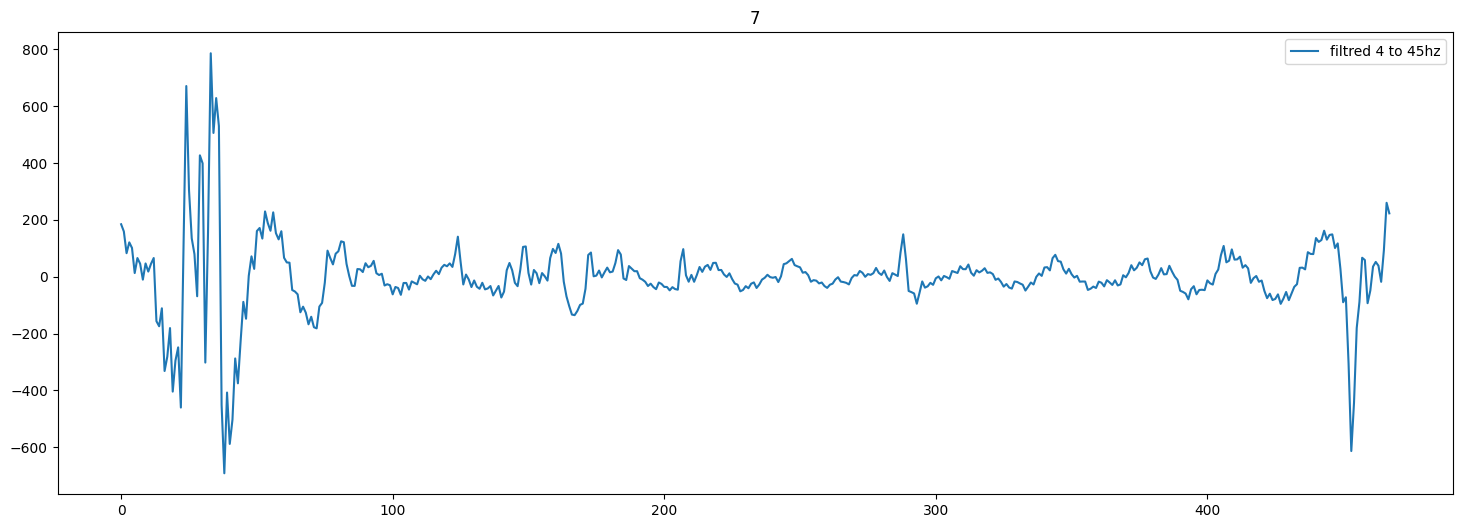

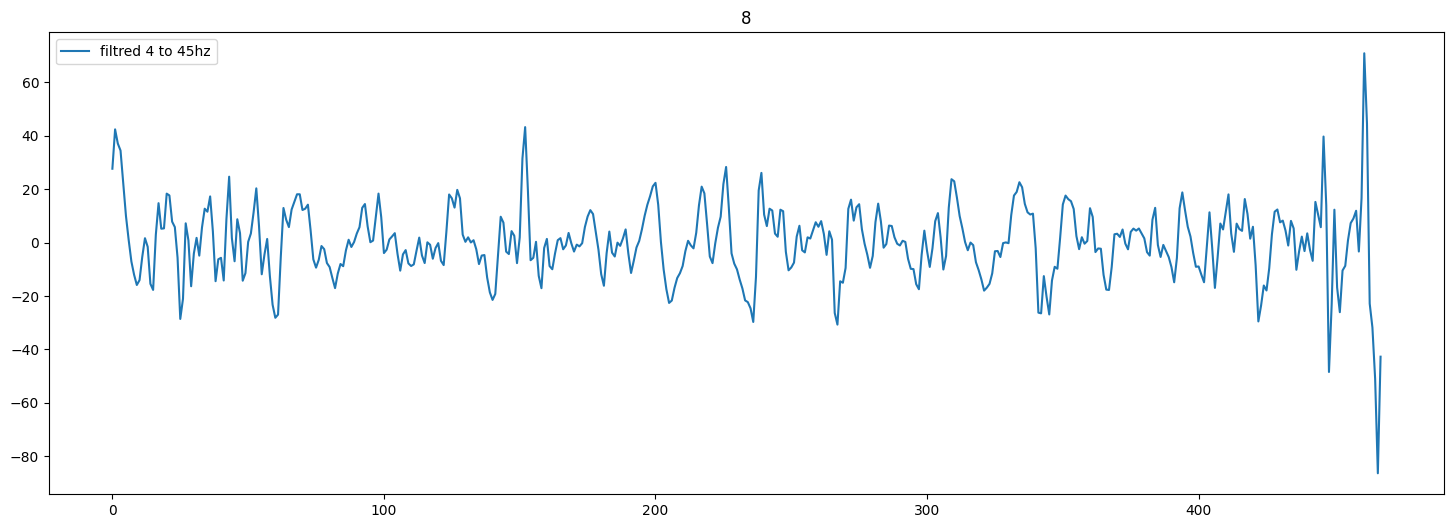

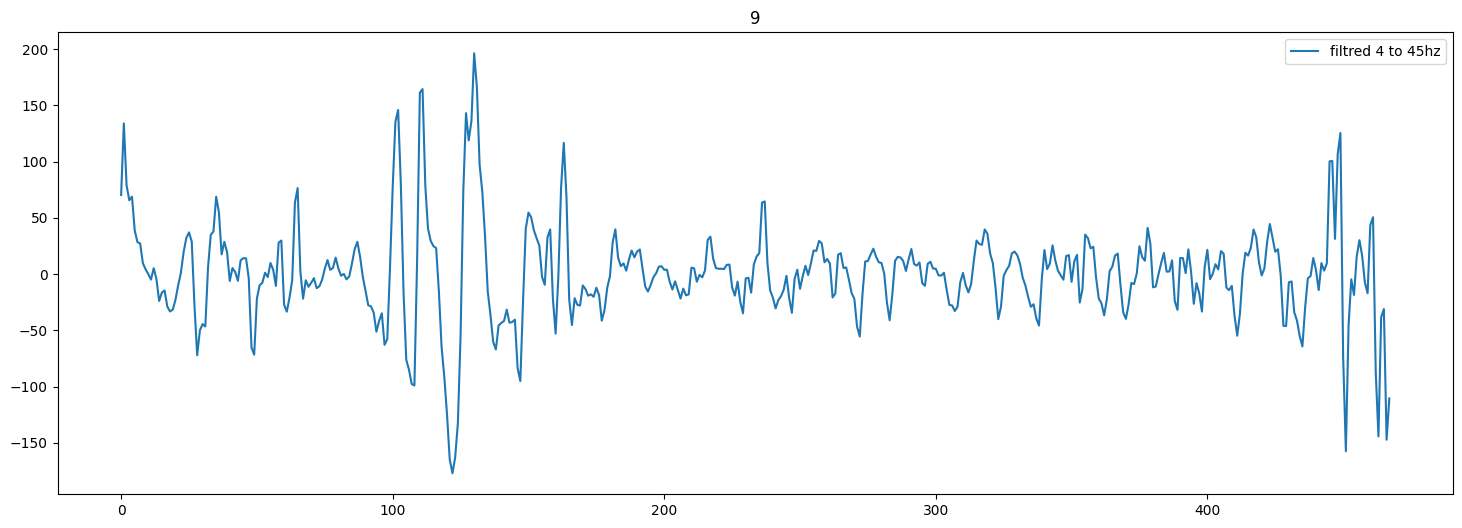

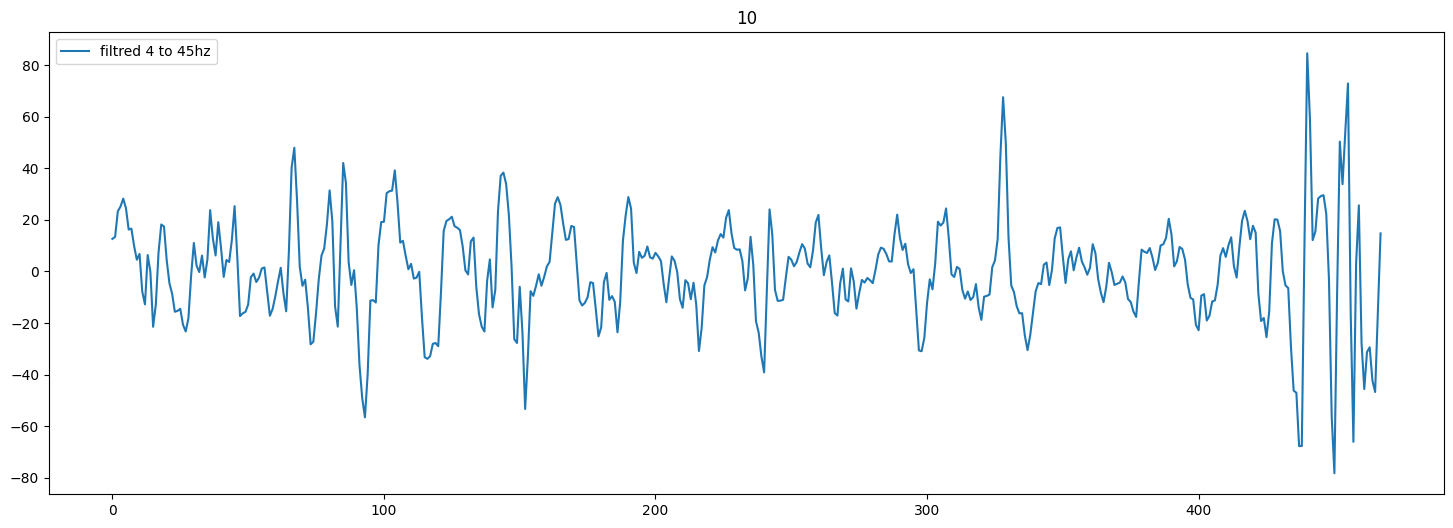

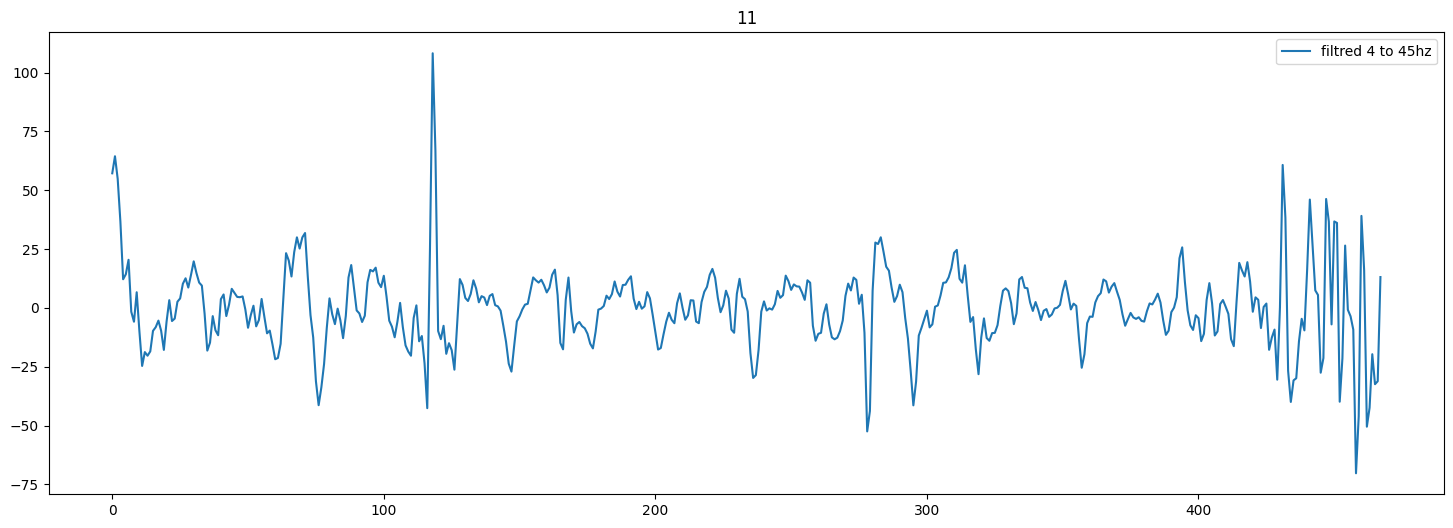

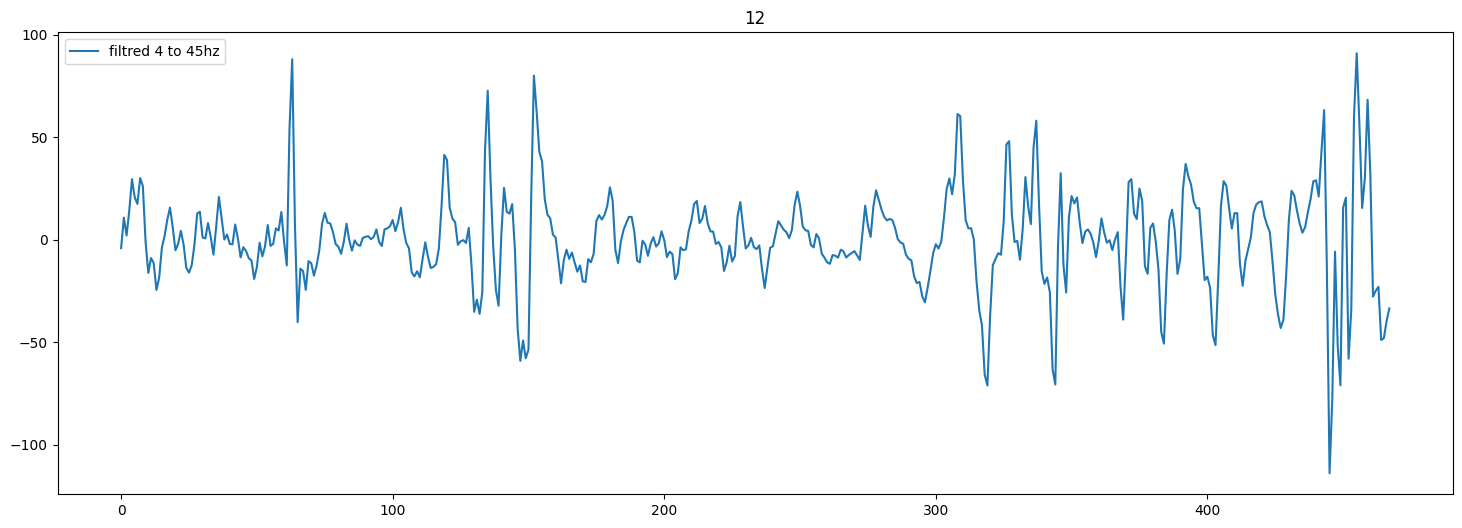

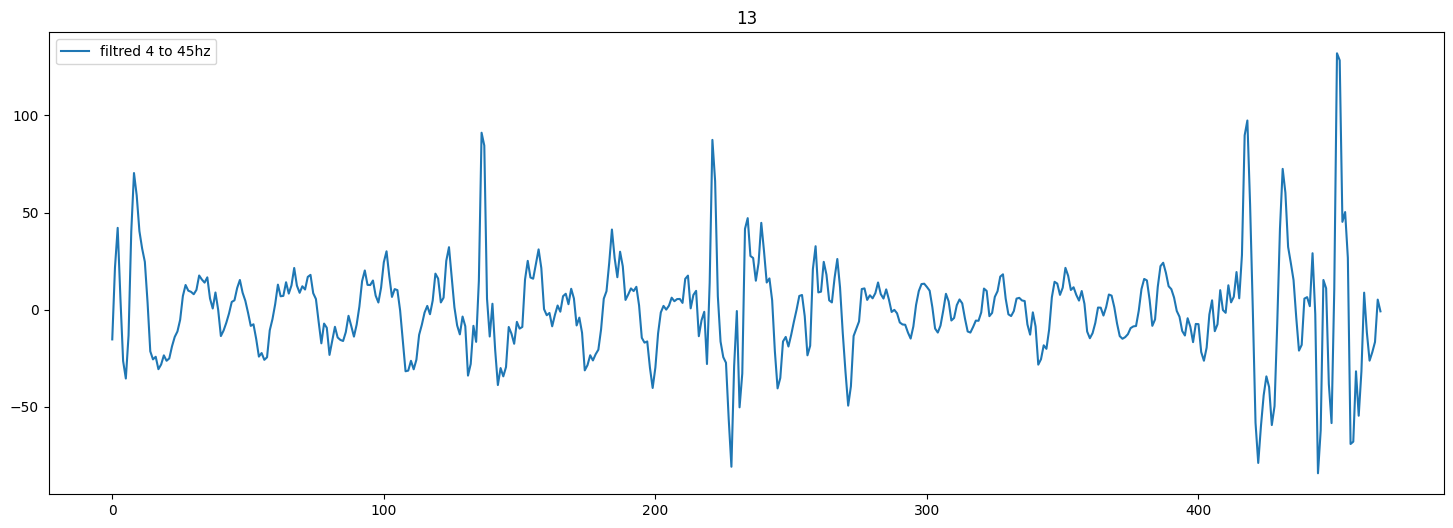

In [52]:
for i in range(14):
    plt.figure(figsize=(18, 6)) 
    plt.plot(data_segment_fp1_128[i],label='filtred 4 to 45hz')
    plt.title(str(i))
    plt.legend(loc='best')
    plt.show()

In [53]:
#дополнительное удаление аномальных значений, много шумов
for i in range(len(data_segment_fp1_128)):
    data_segment_fp1_128[i] = check_anomaly(data_segment_fp1_128[i])

for i in range(len(data_segment_fp2)):
    data_segment_fp2_128[i] = check_anomaly(data_segment_fp2_128[i])

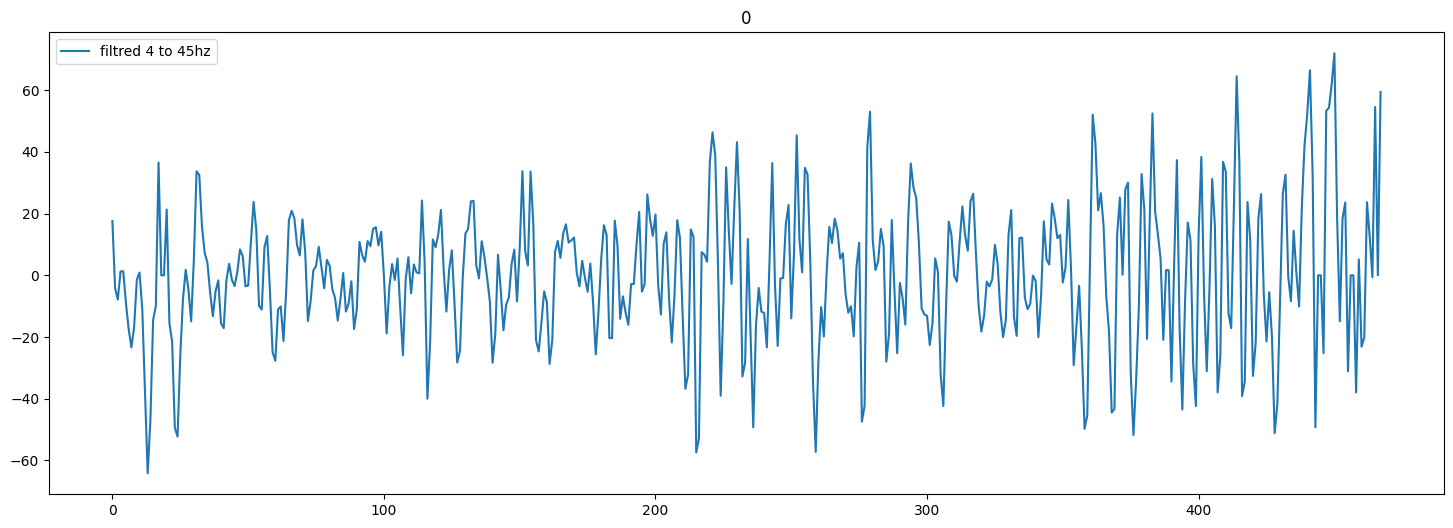

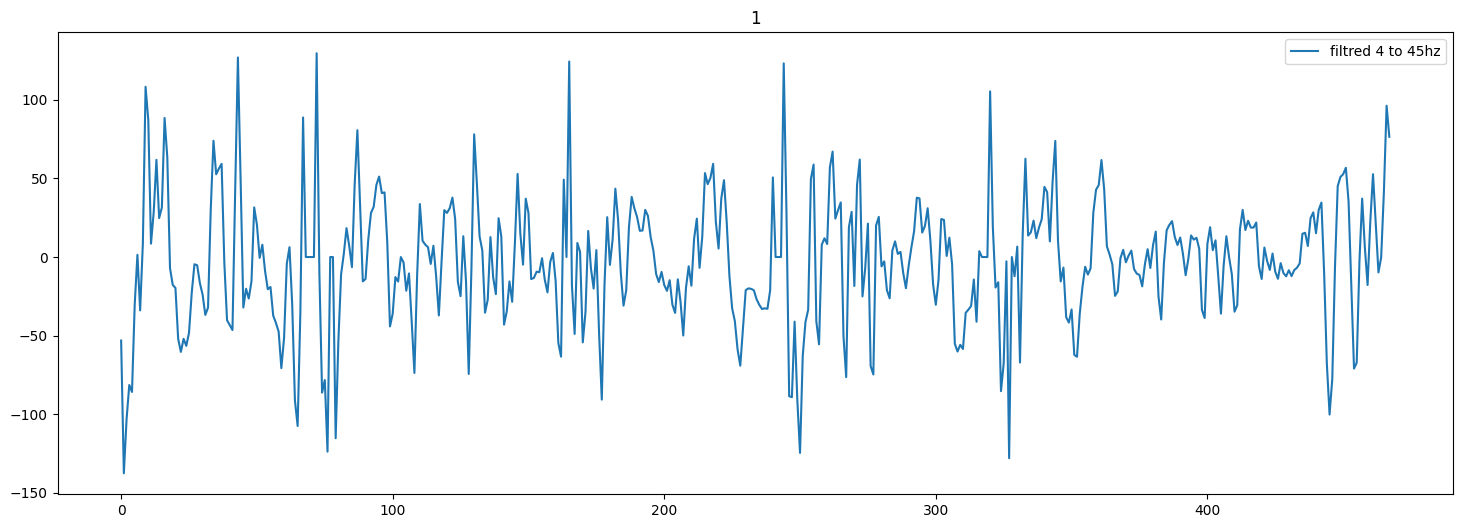

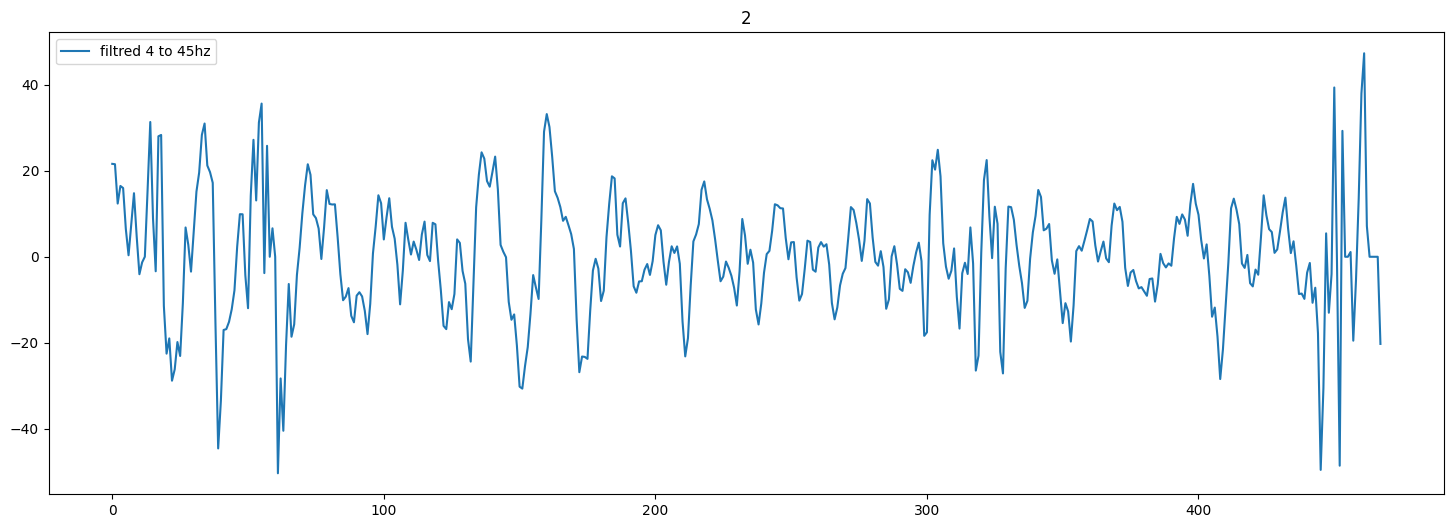

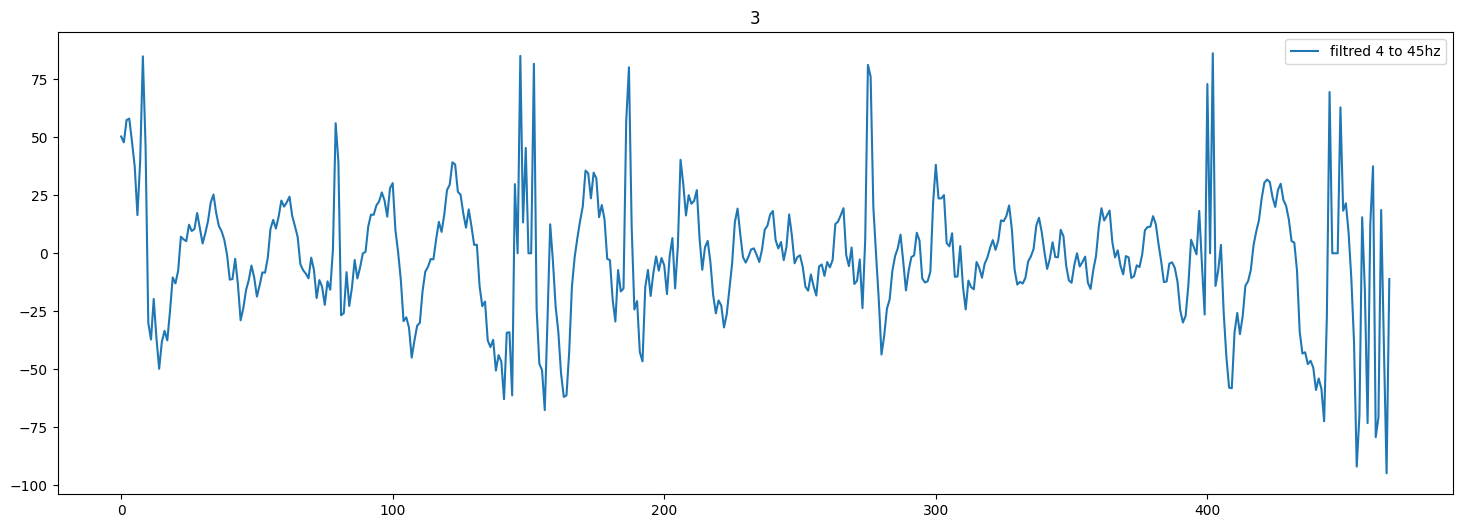

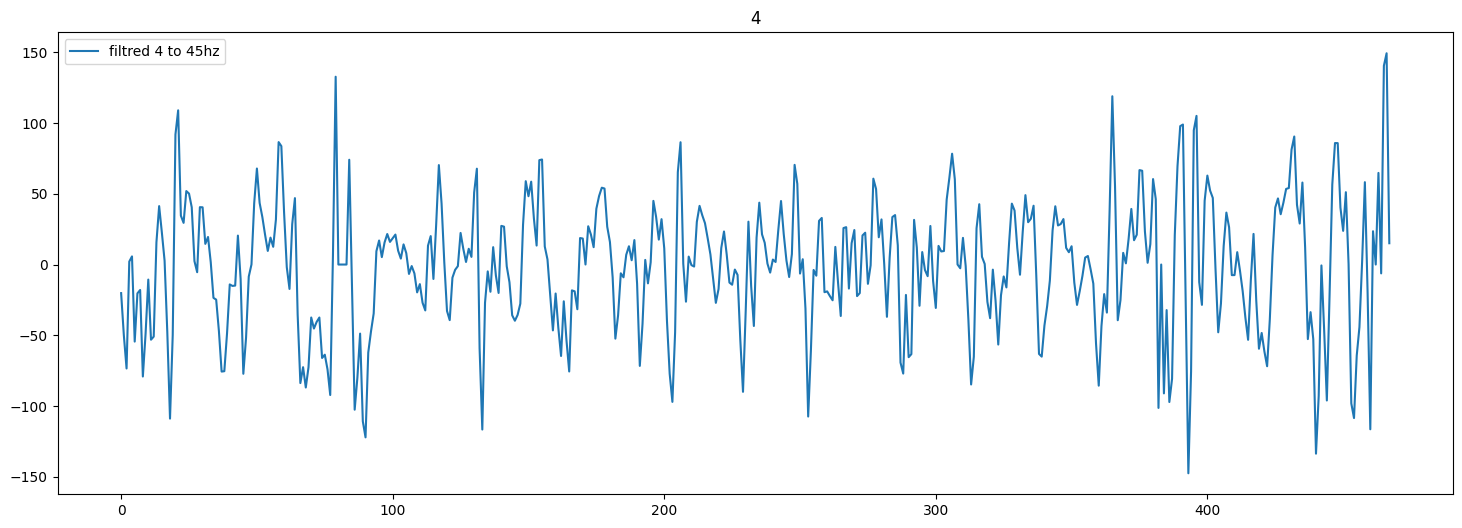

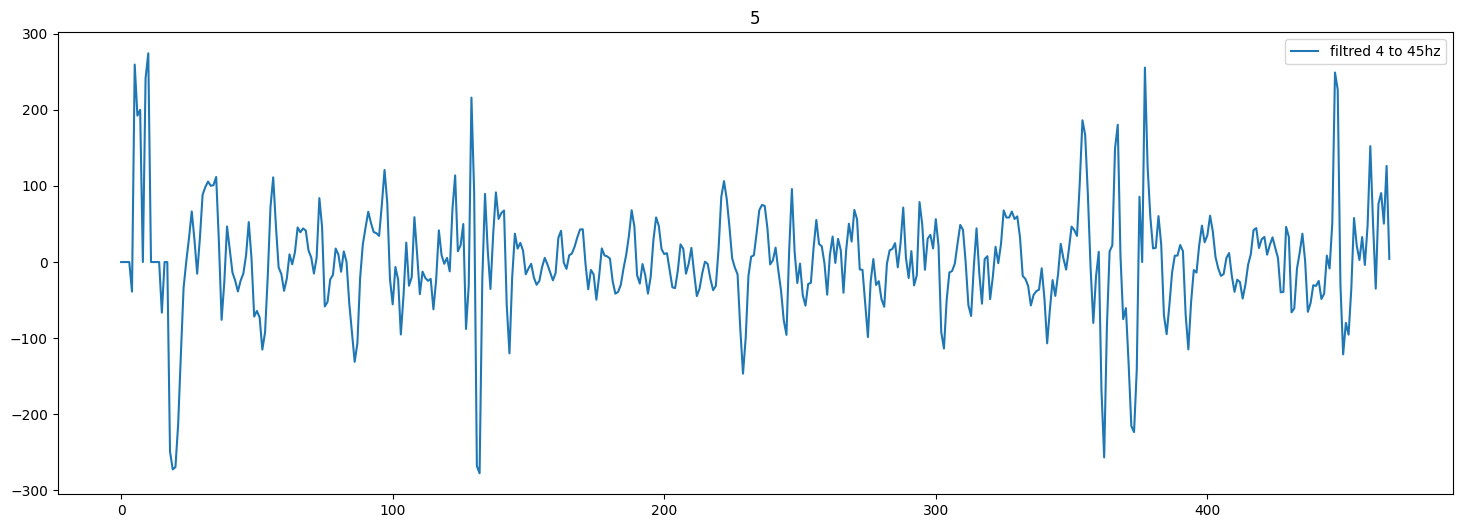

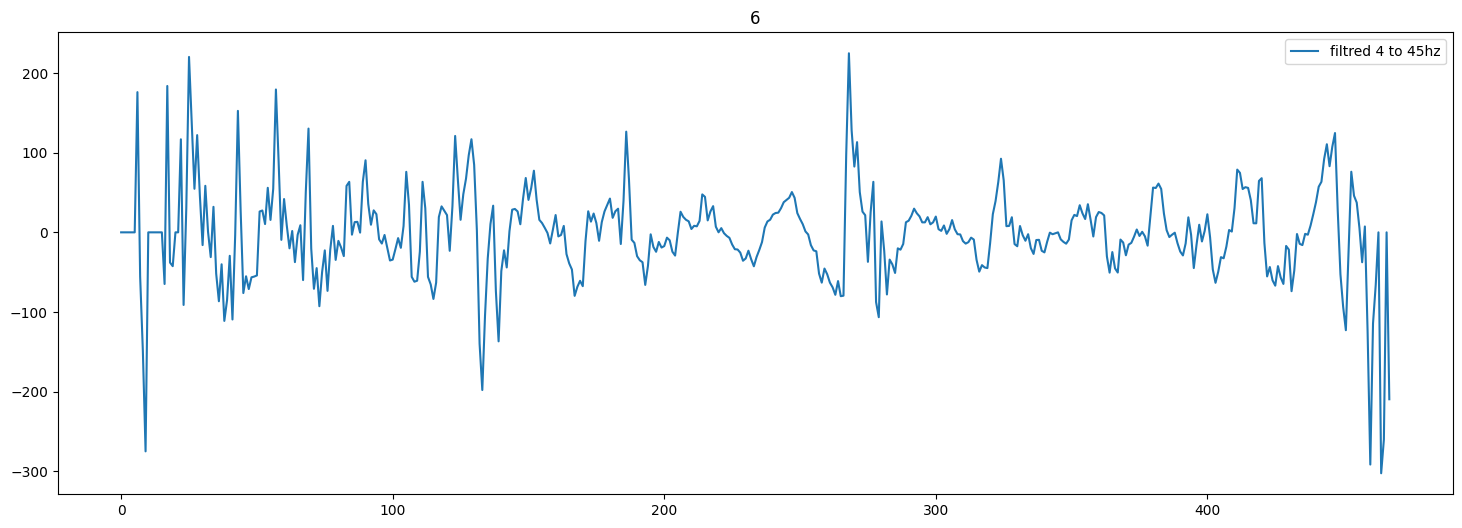

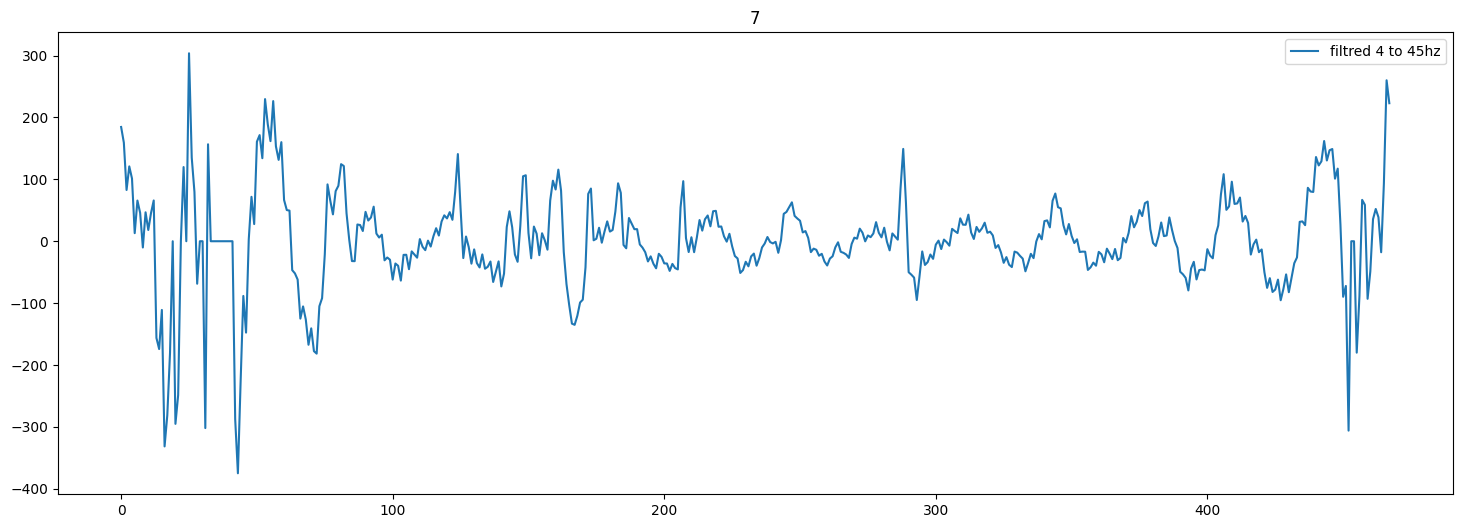

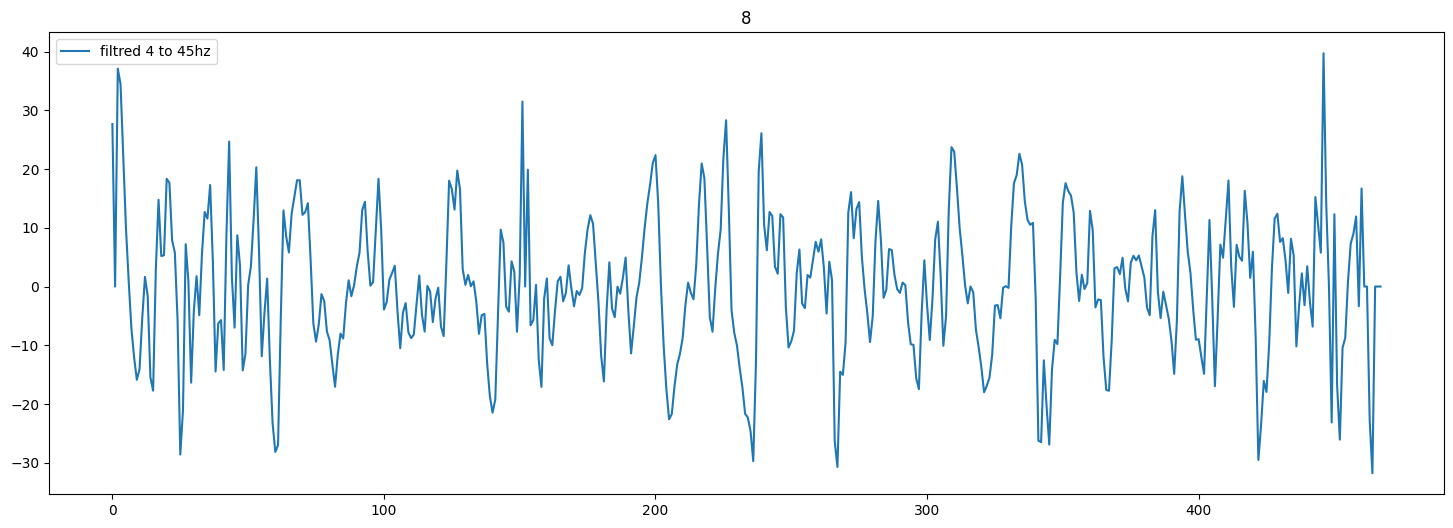

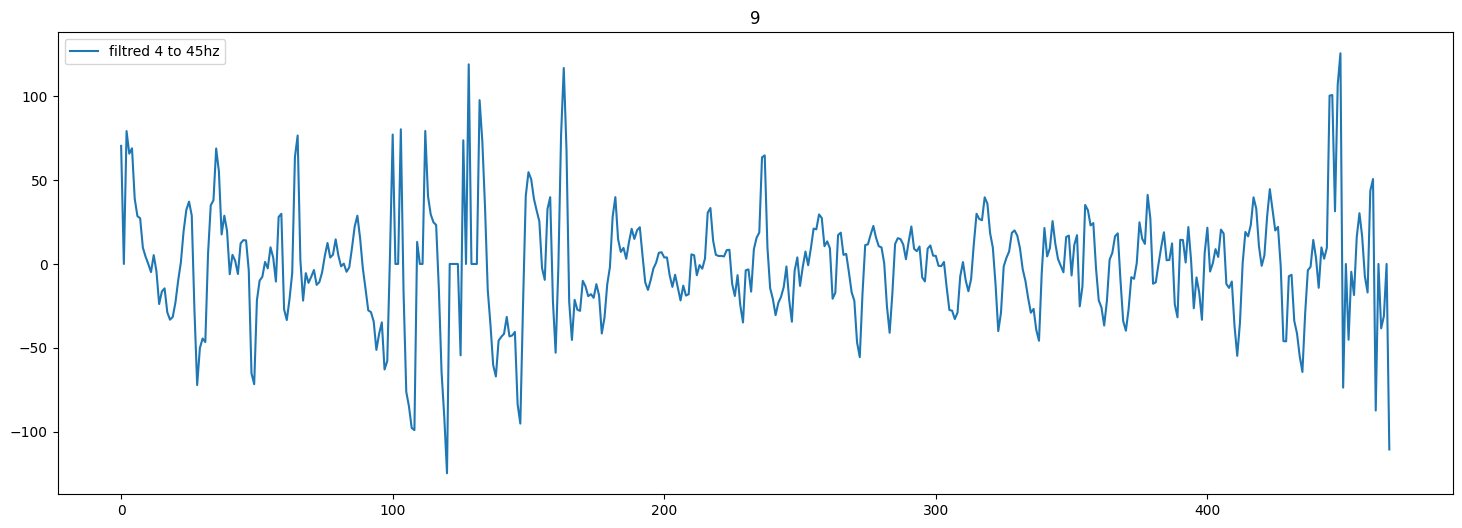

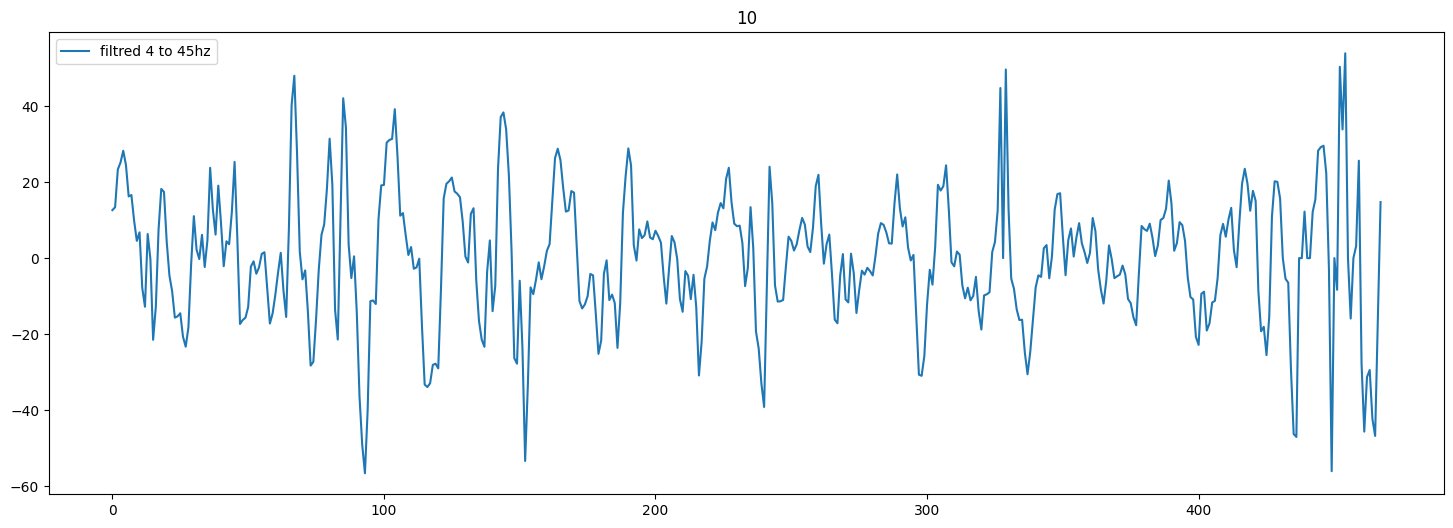

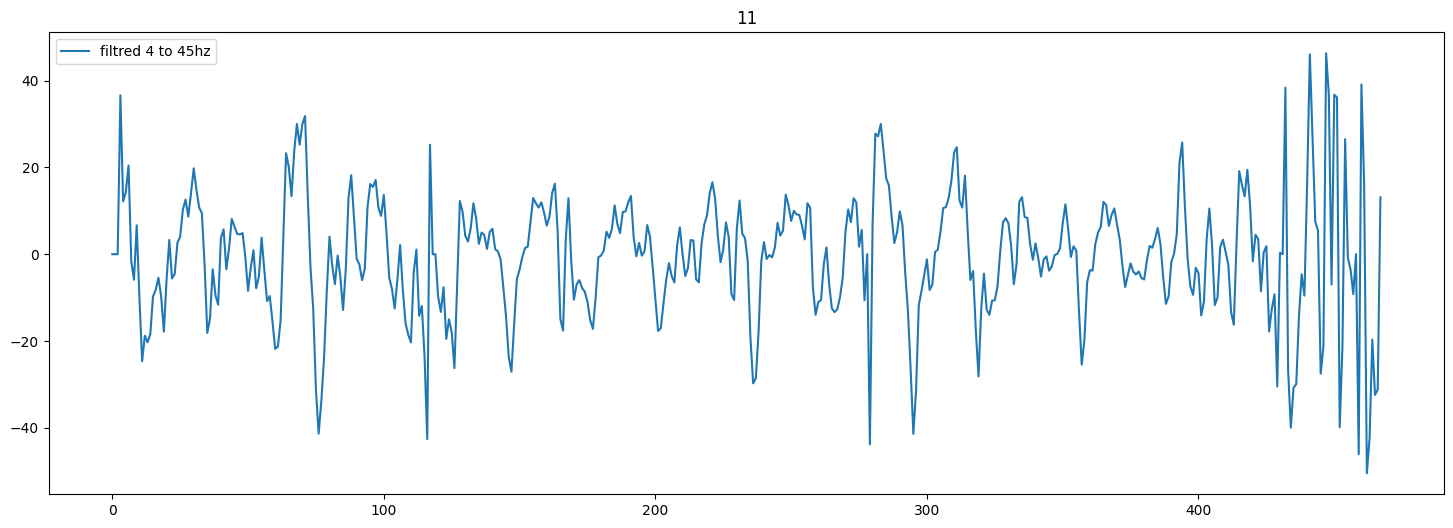

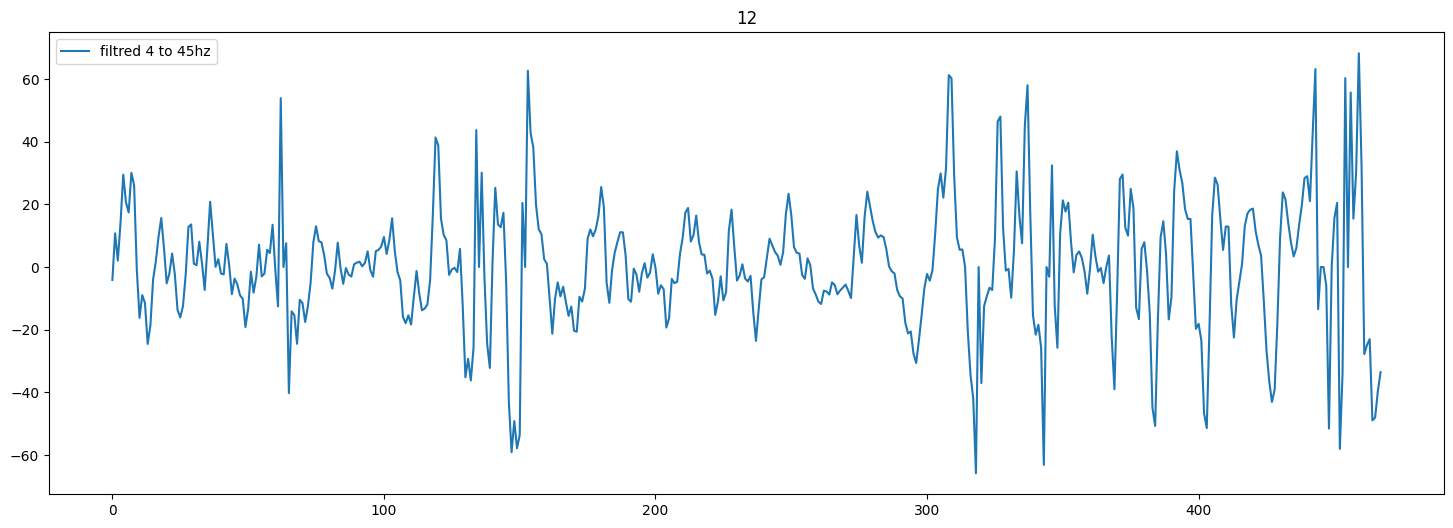

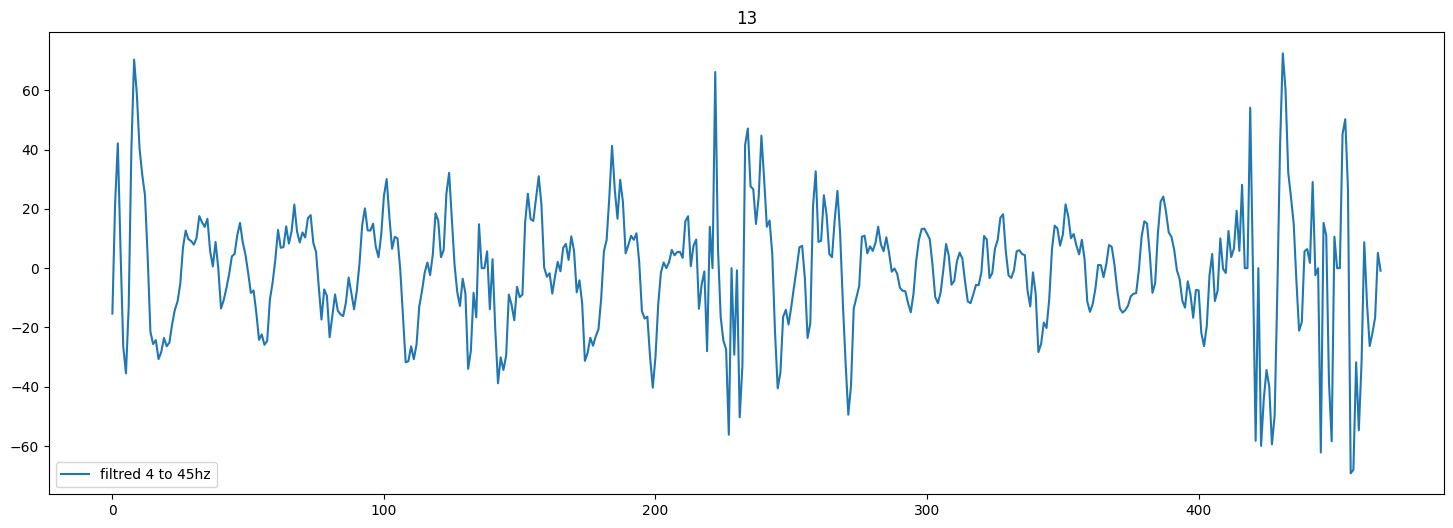

In [54]:
for i in range(14):
    plt.figure(figsize=(18, 6)) 
    plt.plot(data_segment_fp1_128[i],label='filtred 4 to 45hz')
    plt.title(str(i))
    plt.legend(loc='best')
    plt.show()

In [55]:
indexes_to_save = [0,1,2,4,8,10,11,13]

In [56]:
data_fp1_to_save = []
for elem in indexes_to_save:
    data_fp1_to_save.append(data_segment_fp1_128[elem])

In [57]:
data_fp2_to_save = []
for elem in indexes_to_save:
    data_fp2_to_save.append(data_segment_fp2_128[elem])

In [58]:
pd.DataFrame(data_fp1_to_save).to_csv('bioradio_2_fp1.csv')
pd.DataFrame(data_fp2_to_save).to_csv('bioradio_2_fp2.csv')

In [59]:
raitings = pd.DataFrame(columns=['valence','arousal','dominance','liking'])
raitings['valence'] = [7,9,5,7,9,9,7,6,6,6,3,6,5,2]
raitings['arousal'] = [5,9,3,4,9,9,6,7,8,3,1,5,2,1]
raitings['dominance'] = [7,9,3,5,9,9,8,6,7,4,2,4,3,2]
raitings['liking'] = [4,5,3,3,5,5,4,4,4,3,2,3,2,2]
raitings

,valence,arousal,dominance,liking
0,7,5,7,4
1,9,9,9,5
2,5,3,3,3
3,7,4,5,3
4,9,9,9,5
5,9,9,9,5
6,7,6,8,4
7,6,7,6,4
8,6,8,7,4
9,6,3,4,3


In [60]:
valence = []
for elem in raitings['valence']:
    if elem >= 5:
           valence.append(1)
    else:
           valence.append(0)
raitings['valence_model'] = valence

arousal = []
for elem in raitings['arousal']:
    if elem >= 5:
           arousal.append(1)
    else:
           arousal.append(0)
raitings['arousal_model'] = arousal

In [61]:
raitings

,valence,arousal,dominance,liking,valence_model,arousal_model
0,7,5,7,4,1,1
1,9,9,9,5,1,1
2,5,3,3,3,1,0
3,7,4,5,3,1,0
4,9,9,9,5,1,1
5,9,9,9,5,1,1
6,7,6,8,4,1,1
7,6,7,6,4,1,1
8,6,8,7,4,1,1
9,6,3,4,3,1,0


In [62]:
raitings = raitings.drop(index=[3,5,6,7,9,12])
raitings

,valence,arousal,dominance,liking,valence_model,arousal_model
0,7,5,7,4,1,1
1,9,9,9,5,1,1
2,5,3,3,3,1,0
4,9,9,9,5,1,1
8,6,8,7,4,1,1
10,3,1,2,2,0,0
11,6,5,4,3,1,1
13,2,1,2,2,0,0


In [63]:
raitings.to_csv('bioradio_raiting_2.csv')